# Define function to plot RMSE vs Number of Features and training set size for K-fold Cross Validation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math

def k_fold_plot_RMSE_vs_noOfFeatures(X, y, k, features, jump, entries):
    
    entries -= entries%k
    X = X[:entries, :]
    y = y[:entries]

    uval = math.floor(entries/k)

    test_ratio = math.floor(uval/100)
    train_ratio = 1 - test_ratio
    n = math.floor(features/jump)

    TMSE = np.ones((features, 1))
    RMSE = np.ones((features, 1))

    X = X.reshape(k, uval, features)
    y = y.reshape(k, uval, 1)
    RMSE_indi = np.ones((features,k))
    RMSE_SD = np.ones((features, 1))

    for feature in range(features):
        MSE = 0
        for i in range(k):
    
            X_test = X[i:i+1, :, :(feature+1)]
            X_test = X_test.reshape(uval, (feature+1))
            X_test = np.append(arr = np.ones((uval, 1)), values = X_test, axis=1)

            y_test = y[i:i+1, :, :]
            y_test = y_test.reshape(uval)
    
            X_train = np.concatenate((X[:i , :, :(feature+1)], X[i+1:, :, :(feature+1)])) # Upper SIP, middle SIP is test, Lower SIP
            X_train = X_train.reshape(entries-uval,(feature+1))
            X_train = np.append(arr = np.ones((entries-uval, 1)), values = X_train, axis=1)
        
            xT = X_train.transpose()
            xTx = np.dot(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx) 
        
            y_train = np.concatenate((y[:i , :, :], y[i+1:, :, :]))
            y_train = y_train.reshape(entries-uval)
            xTy = np.dot(xT, y_train)
            w = np.dot(xTx_pinv, xTy).reshape(feature+2,1)
            y_pred = np.dot(X_test,w).reshape(X_test.shape[0])
            abs_err = abs(y_pred-y_test)
            MSE += np.mean((abs_err)**2)
            RMSE_indi[feature][i] = (np.mean((abs_err)**2))**0.5
        
        TMSE[feature] = MSE/k
        RMSE[feature] = TMSE[feature]**0.5 
    

    reqdRMSE = np.ones((n,1))

    for i in range(features):
        RMSE_SD[i] = RMSE_indi[i].std()


    for i in range(n):
        reqdRMSE[i] = RMSE[(i+1)*jump - 1]
    
    X_vals_plot = list(range(1,n+1))
    X_vals_plot = np.multiply(X_vals_plot, jump)


    print(k,"-Fold Cross Validation with", entries, "entries", features, "max-features and jump-value", jump)
    plt.errorbar(list(range(1,features+1)), RMSE, yerr=RMSE_SD, color="blue", errorevery = jump, capsize=3, ecolor="red")
    # plt.scatter(X_vals_plot.reshape(n,1), reqdRMSE, color="black", s=10)
    plt.xlabel("Number of features")
    plt.ylabel("Root Mean squared error")
    plt.title("K-Fold Cross Validation RMSE vs No.of.features in linear regression")
    plt.show()

    plt.plot(X_vals_plot.reshape(n,1), reqdRMSE, color="red")
    plt.scatter(X_vals_plot.reshape(n,1), reqdRMSE, color="black")
    plt.xlabel("Number of features")
    plt.ylabel("Root Mean squared error")
    plt.show()


def k_fold_plot_RMSE_vs_training_set_size(X, y, k, features, jump, entries):
    
    entries -= entries%k
    X = X[:entries, :]
    y = y[:entries]
    
    uval = math.floor(entries/k)
    test_ratio = math.floor(uval/100)
    train_ratio = 1 - test_ratio
    n = math.floor(features/jump)
    m = math.floor((entries-uval)/jump)

    X = X.reshape(k*uval, features)
    y = y.reshape(k*uval)
    
    RMSE_per_fold = np.ones((m, k))
    RMSE_SD_per_fold = np.ones((m, k))
    X_val = np.ones((m))

    for l in range(k):

        X_test = X[uval*l:(uval*l)+uval]
        X_test = np.append(arr = np.ones((uval, 1)), values = X_test, axis=1)
        y_test = y[uval*l:(uval*l)+uval]
        
        TRMSE_SD = np.ones((k-1, 1))
        RMSE = np.ones((k-1))
        
        X_without_XTest = X[:uval*l, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(uval*l)+uval:, :]).reshape(entries-uval, features)
        y_without_yTest = y[:uval*l]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(uval*l)+uval:])

        num = m
        
        for i in range(m):
            X_val[i] = (i+1)*jump
            
            RMSE_indi = np.ones((num))
            MSE = 0
            sqr_err = np.zeros((y_test.shape[0]))
            for j in range(num):
                X_train = X_without_XTest[j*jump:(i+j)*jump+(jump), :]
                X_train = np.append(arr = np.ones((X_train.shape[0],1)), values = X_train, axis=1)
        
                y_train = y_without_yTest[j*jump:(i+j)*jump+(jump)]

                xT = X_train.transpose();
                xTx = np.dot(xT, X_train)
                xTx_pinv = np.linalg.pinv(xTx)
                xTy = np.dot(xT, y_train)
                w = np.dot(xTx_pinv, xTy).reshape(features+1, 1)
        
                y_pred = np.dot(X_test,w).reshape(X_test.shape[0])
                sqr_err += abs(y_pred-y_test)**2
        
                RMSE_indi[j] = (np.mean(abs(y_pred-y_test)**2)**0.5)
        
#             print(sqr_err)
            RMSE_per_fold[i][l] = np.mean(RMSE_indi)
            RMSE_SD_per_fold[i][l] = RMSE_indi.std()
            num -= 1
            
    
    X_val = X_val.astype(int)
    total_RMSE = sum(RMSE_per_fold.transpose())/5
    total_RMSE_SD = sum(RMSE_SD_per_fold.transpose())/5
    
    plt.scatter(X_val, total_RMSE, color="black", s=10)
    plt.errorbar(X_val, total_RMSE, yerr=total_RMSE_SD, color="blue", ecolor="red", capsize=3)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title("Train set size vs RMSE for k-fold cross validation")
    plt.show()

# entries = 1000
# k=5
# jump = 100
# features = 500
# X, y = make_regression(n_samples = entries, n_features = features, noise = 50)

# k_fold_plot_RMSE_vs_training_set_size(X, y, k, features, jump, entries)
    

5 -Fold Cross Validation with 5870 entries 62 max-features and jump-value 5


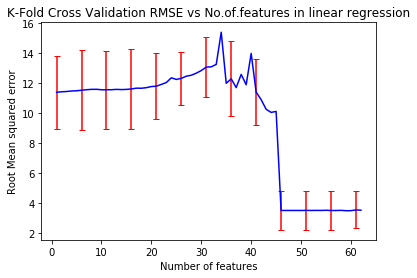

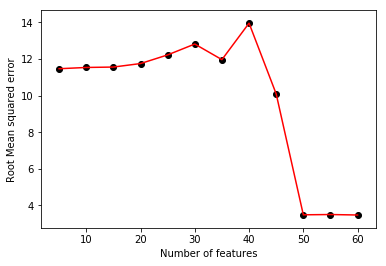

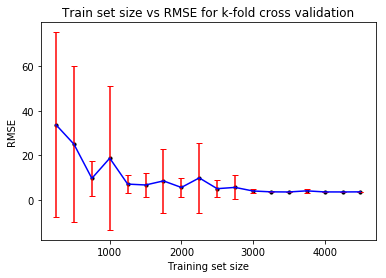

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas.compat import StringIO

df = pd.read_csv("parkinsons_updrs.data", 
                 sep="\s+", 
                 skiprows=1,
                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], 
                 names=['subject','age','sex','test_time','motor_UPDRS','total_UPDRS','Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP','Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA','NHR','HNR','RPDE','DFA','PPE'])

y = df.iloc[:, 5].values # total_UPDRS
y2 = df.iloc[:, 4].values # motor_UPDRS

df = df.drop(['total_UPDRS'], axis='columns')

subject_dummies = pd.get_dummies(df.subject).iloc[:, :-1]
df = pd.concat([subject_dummies, df], axis='columns')
X = df.iloc[:, :].values

k = 5
features = X.shape[1] # 5874
entries = X.shape[0]
feature_jump = 5
k_fold_plot_RMSE_vs_noOfFeatures(X, y, k, features, feature_jump, entries)
training_set_size_jump = 250
k_fold_plot_RMSE_vs_training_set_size(X, y, k, features, training_set_size_jump, entries)

